# Part 3: Neural Networks for Neural Data of a single Participant

First we load the necessary libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [2]:
tf.random.set_seed(13)

Move EEGNet to external file, and see how to get it with git

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [4]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

#### Exercise 1: Training the first neural network on patient 902

- Load the .fif file that we used before. 
- Extract the data and labels
- As descibed in the lecture we need to normalize the data (each trial seperately)
- And we should use one-hot encoded labels, we can use the function 'to_categorical' from tensorflow.keras.utils

In [5]:
data_file = 'PDDys/902-P'
#data_file = 'https://github.com/fma0/AMLD/blob/main/PDDys/902-P'

In [6]:
# solution
def normalize(volume):
    stdev = np.std(volume, dtype=np.float64)
    mean = np.mean(volume, dtype=np.float64)
    return (volume - np.float32(mean)) / np.float32(stdev)

In [7]:
# solution
epochs = mne.read_epochs(data_file + '.fif', verbose='error')
data = np.expand_dims(epochs.get_data(), axis=-1)
labels = np.where(epochs.events[:,-1] == 201, 0, 1)
trial_shape = data.shape[1:]
labels = to_categorical(labels)
for i, sample in enumerate(data):
    data[i] = normalize(sample)

In the next step you should create the train and test sets

In [8]:
# solution
train_data, test_data, labels_train, labels_test = train_test_split(data, labels, 
                                                                    test_size=0.3, 
                                                                    random_state=42)


Now let's define the model, it takes as input : the number of classes, the number of recorded EEG channels and the number of time points per trial.

We are using EEGNet, which was developped by Lawhern et. al. (2017) https://github.com/vlawhern/arl-eegmodels

In [9]:
# solution
n_classes = 2
n_channels = data.shape[1]
n_timepoints = data.shape[2]

In [10]:
model = EEGNet(n_classes, n_channels, n_timepoints)

2022-03-23 16:43:34.957769: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 16:43:34.958009: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Before training we need to compile the network, there we specify the loss, optimizer, learning rate and any other metric that we would like to keep track of. 
We currently keep track of the accuracy and the AUC score, you are free to add anything else you find meaningfull. Check out https://www.tensorflow.org/api_docs/python/tf/keras/metrics for a list of possibilities. 

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', lr=0.1, metrics=['accuracy', 'AUC'])

Then we train the model for 50 epochs. We set the percentage of trials for the validation set with the variable validation_split (here 20%). 

In [12]:
history = model.fit(train_data, labels_train, validation_split=0.2, epochs=50)

Train on 85 samples, validate on 22 samples
Epoch 1/50
85/85 [==============================] - 3s 38ms/sample - loss: 0.7038 - accuracy: 0.5882 - AUC: 0.6188 - val_loss: 0.6889 - val_accuracy: 0.7727 - val_AUC: 0.7097
Epoch 2/50
85/85 [==============================] - 1s 9ms/sample - loss: 0.6498 - accuracy: 0.6706 - AUC: 0.7508 - val_loss: 0.6871 - val_accuracy: 0.7727 - val_AUC: 0.7469
Epoch 3/50
85/85 [==============================] - 1s 9ms/sample - loss: 0.6174 - accuracy: 0.7882 - AUC: 0.8257 - val_loss: 0.6853 - val_accuracy: 0.7727 - val_AUC: 0.7304
Epoch 4/50
85/85 [==============================] - 1s 9ms/sample - loss: 0.5880 - accuracy: 0.7882 - AUC: 0.8574 - val_loss: 0.6832 - val_accuracy: 0.7727 - val_AUC: 0.7211
Epoch 5/50
85/85 [==============================] - 1s 9ms/sample - loss: 0.5540 - accuracy: 0.8118 - AUC: 0.8720 - val_loss: 0.6808 - val_accuracy: 0.7727 - val_AUC: 0.7293
Epoch 6/50
85/85 [==============================] - 1s 9ms/sample - loss: 0.5378 - ac

Let's evaluate how the learning of the model progressed during the training. The history variable contains the progresssion of the models evaluated on the metrics, that we gave to the model before as well as the loss. The history contains the vlues for the train and validation (called with a prefix of 'val_') metrics. We can see all that it keeps track of with:

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])

In [14]:
def plot_history(history, key):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlabel('Epochs')
    ax.set_ylabel(key.capitalize())

    plt.plot(history.history[key], color='C0', label = 'Train', linewidth=2)
    plt.plot(history.history['val_'+key], color='C3', label='Validation', linewidth=2)

    legend = ax.legend(fontsize='medium')
    ax.set_title('Model ' + key.capitalize())
    plt.show()

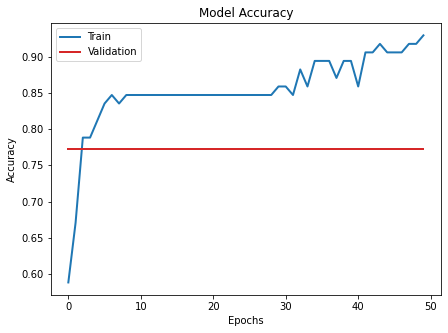

In [15]:
plot_history(history, 'accuracy')

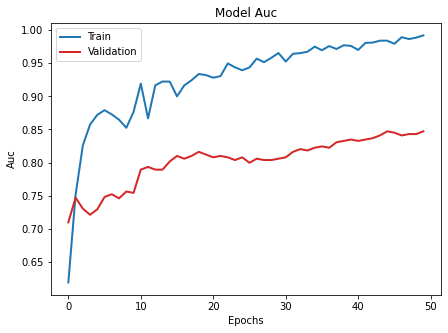

In [16]:
plot_history(history, 'AUC')

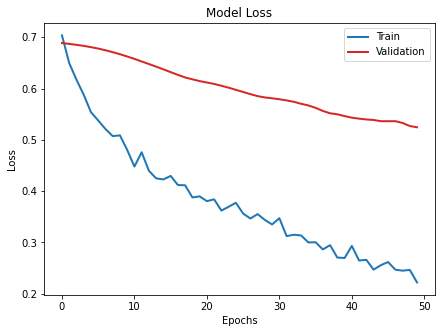

In [17]:
plot_history(history, 'loss')

Now we test the networks performance on the test set. We use the same function as in the previous notebook :

In [18]:
predictions = np.argmax(model.predict(test_data), axis=1)

In [19]:
print(predictions)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


In [20]:
labels_test_true = np.argmax(labels_test, axis=1)
report_eegnet = classification_report(labels_test_true, predictions, target_names=['Standard', 'Novel'])
print('EEGNet Clasification Report:\n {}'.format(report_eegnet))

acc_eegnet = accuracy_score(labels_test_true, predictions)
print("Accuracy of EEGNet model: {}".format(acc_eegnet))

precision_eegnet,recall_eegnet,fscore_eegnet,support_eegnet=precision_recall_fscore_support(labels_test_true,
                                                                                predictions,
                                                                                average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_eegnet,recall_eegnet,fscore_eegnet))

EEGNet Clasification Report:
               precision    recall  f1-score   support

    Standard       0.84      1.00      0.92        38
       Novel       1.00      0.22      0.36         9

    accuracy                           0.85        47
   macro avg       0.92      0.61      0.64        47
weighted avg       0.87      0.85      0.81        47

Accuracy of EEGNet model: 0.851063829787234
Precision: 0.9222222222222223, Recall: 0.6111111111111112, f1-score:0.6396495071193866


In [21]:
accuracies, f1_scores = [], []
accuracies.append([acc_eegnet])
f1_scores.append([fscore_eegnet])

How does this compare to the performance of the machine learning algorithms?

#### Excercise 2: Let's optimize the Model

From the documentation of EEGNet we have: 

    def EEGNet(nb_classes, Chans = 64, Samples = 128, 
               dropoutRate = 0.5, kernLength = 64, F1 = 8, 
               D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
 
    [...]

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and [...] (double the kernel lengths for double the sampling rate, etc). 
    Note that we haven't tested the model performance with this rule so this may not work well. 
    
    [...] 
    
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
      
Note that the kernLength needs to be an integer

In [22]:
# solution
kernLength = int(epochs.info['sfreq']/2)

In [23]:
del model, history

In [24]:
model = EEGNet(n_classes, n_channels, n_timepoints, kernLength=kernLength)

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', lr=0.1, metrics=['accuracy', 'AUC'])

In [26]:
history= model.fit(train_data, labels_train, validation_split=0.2, epochs=50)

Train on 85 samples, validate on 22 samples
Epoch 1/50
85/85 [==============================] - 4s 45ms/sample - loss: 0.9347 - accuracy: 0.4000 - AUC: 0.3743 - val_loss: 0.6858 - val_accuracy: 0.7727 - val_AUC: 0.7665
Epoch 2/50
85/85 [==============================] - 2s 18ms/sample - loss: 0.6687 - accuracy: 0.6235 - AUC: 0.6472 - val_loss: 0.6811 - val_accuracy: 0.7727 - val_AUC: 0.7944
Epoch 3/50
85/85 [==============================] - 1s 17ms/sample - loss: 0.6378 - accuracy: 0.7059 - AUC: 0.7547 - val_loss: 0.6769 - val_accuracy: 0.7727 - val_AUC: 0.8213
Epoch 4/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.5976 - accuracy: 0.7647 - AUC: 0.8415 - val_loss: 0.6728 - val_accuracy: 0.8182 - val_AUC: 0.8223
Epoch 5/50
85/85 [==============================] - 2s 19ms/sample - loss: 0.5408 - accuracy: 0.8588 - AUC: 0.8977 - val_loss: 0.6686 - val_accuracy: 0.8182 - val_AUC: 0.8326
Epoch 6/50
85/85 [==============================] - 2s 18ms/sample - loss: 0.5249

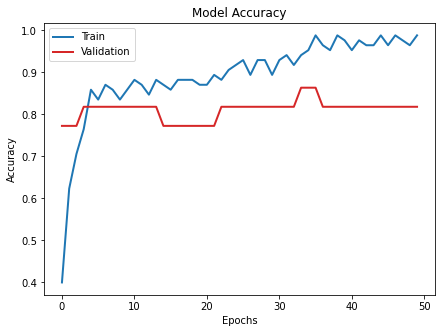

In [27]:
plot_history(history, 'accuracy')

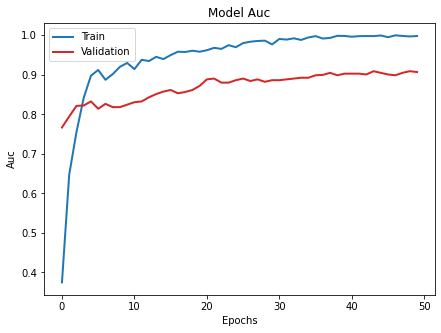

In [28]:
plot_history(history, 'AUC')

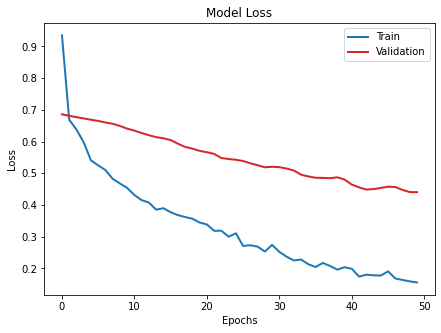

In [29]:
plot_history(history, 'loss')

In [30]:
predictions = np.argmax(model.predict(test_data), axis=1)

In [31]:
labels_test_true = np.argmax(labels_test, axis=1)
report_eegnet = classification_report(labels_test_true, predictions, target_names=['Standard', 'Novel'])
print('EEGNet Clasification Report:\n {}'.format(report_eegnet))

acc_eegnet = accuracy_score(labels_test_true, predictions)
print("Accuracy of EEGNet model: {}".format(acc_eegnet))

precision_eegnet,recall_eegnet,fscore_eegnet,support_eegnet=precision_recall_fscore_support(labels_test_true,
                                                                                predictions,
                                                                                average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_eegnet,recall_eegnet,fscore_eegnet))

EEGNet Clasification Report:
               precision    recall  f1-score   support

    Standard       0.86      0.95      0.90        38
       Novel       0.60      0.33      0.43         9

    accuracy                           0.83        47
   macro avg       0.73      0.64      0.66        47
weighted avg       0.81      0.83      0.81        47

Accuracy of EEGNet model: 0.8297872340425532
Precision: 0.7285714285714285, Recall: 0.6403508771929824, f1-score:0.6642857142857143


In [32]:
accuracies.append([acc_eegnet])
f1_scores.append([fscore_eegnet])

In [33]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    colors = ['#87CEFA', '#FFE4E1', '#CD5C5C']# the colors of the bars (max 3)
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects = [np.arange(len(evalMetric[:][0]))]
    for i in range(len(labels)-1):
        rects.append([x + width for x in rects[-1]])

    for i in range(len(labels)):
        plt.bar(rects[i], evalMetric[i], color=colors[i], width=width, edgecolor='white', 
                    label=labels[i])

    plt.xlabel('Classification Tasks')
    plt.xticks([r + width for r in range(len(tasks))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

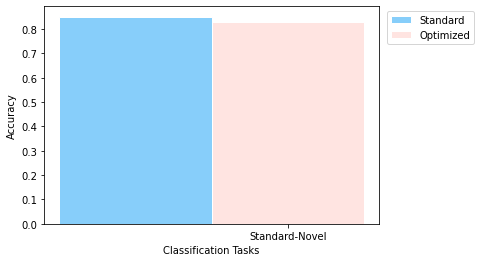

[[0.851063829787234], [0.8297872340425532]]


In [34]:
#Plot Accuracies
tasks = ['Standard-Novel']
labels = ['Standard', 'Optimized']
plotEvalMetrics(tasks, labels, accuracies, 'Accuracy')
print(accuracies)

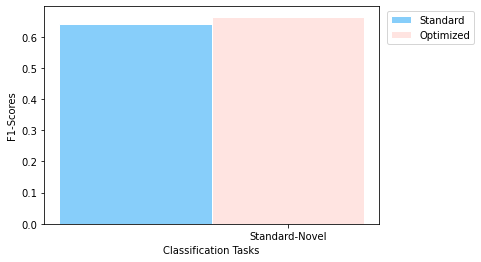

In [35]:
#Plot F1 Scores
tasks = ['Standard-Novel']
labels = ['Standard', 'Optimized']
plotEvalMetrics(tasks, labels, f1_scores, 'F1-Scores')